<h3>3. Använd LSTM men ta ut sequence output per paragraf. Ta därefter global average.</h3>

<p>Denna modellen använder också ett LSTM-lager, fast på en paragraf i taget. Därefter tas ett snitt över dessa.</p>

In [2]:
from sentence_transformers import SentenceTransformer, models
import os
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import torch
import torch.nn as nn
import re
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

<p>Data över uttalanden:</p>

In [3]:
# The directory where data is located
data_dirs = ["test_data/22_23/","test_data/21_22/","test_data/20_21/"]
data = []
for data_dir in data_dirs:
    for file in os.listdir(data_dir):
        if file.endswith(".txt"):
            with open(data_dir+file,"r") as f:
                data.append([])
                for line in f.readlines():
                    data[-1].append(line)

data = np.array(data)

# Print first and last data points
#print(data[0])
#print(data[-1])

# Get only speeches
speeches = data[:,1]

<p>För varje uttalande vill vi extrahera alla paragrafer och associera dem till rätt parti.</p>

In [16]:
possible_parties = ["S","SD","M","V","C","MP","KD","L"]
regex_string = "\(("+str.join("|",possible_parties)+")\)"
print(regex_string)

parties = []
sentences = []
speech_index = 0
# speech_indices[i] will be the paragraph number that speech i begins with
speech_indices = []
# paragraph_indices[j] will be the sentence number that paragraph j begins with
paragraph_indices = []
paragraph_index = 0
# So to get the sentences we want we need to do
# paragraph_start = speech_indices[i]
# paragraph_stop = speech_indices[i+1]
# for j in range(paragraph_start,paragraph_stop):
#   sentence_start = paragraph_indices[j]
#   sentence_stop = paragraph_indices[j+1]
#   sentences_to_use = sentences[sentence_start:sentence_stop]

no_match = 0
for i in range(data.shape[0]):
    line = data[i,0]
    party = "None"
    match = re.search(regex_string,line)
    if match:
        party = match.group()[1:-1]
        speech = data[i,1]
        soup = BeautifulSoup(speech, 'html.parser')
        ps = soup.find_all("p")
        p_count = 0
        for p in ps:
            text = p.get_text()
            if text != "":
                # We count paragraphs to know how much to increase paragraph index
                p_count += 1
                s_count = 0
                for s in re.split("\. |\! |\? ",text):
                    if s != "":
                        s_count += 1
                        sentences.append(s)
                        parties.append(party)
                paragraph_indices.append(paragraph_index)
                paragraph_index += s_count      
        # We add the current index to first index list
        speech_indices.append(speech_index)
        speech_index += p_count
    else:
        no_match += 1
    

parties = np.array(parties)
sentences = np.array(sentences)

\((S|SD|M|V|C|MP|KD|L)\)


In [17]:
print(speech_indices[:5])
print(data[:5])

[0, 3, 5, 18, 21]
[['Anf. 125 Johan Hultberg (M)\n'
  '<p>Herr talman! Jag måste tyvärr säga att jag tycker att ledamoten Sundin läser Tidöavtalet som fan läser Bibeln. Det finns en väldigt stark ambition från Moderaterna och de samarbetspartier som har skrivit under avtalet att vi ska fortsätta just den utveckling med en god och nära vård som jag tycker att ledamoten beskriver väl. Det är en ambition som vi brett över parti- och blockgränser har varit överens om. Vi vill att vården ska komma närmare patienterna. Vi vill att vården ska komma närmare dem som behöver vård och omsorg.</p><p>Vi har viktiga satsningar i Tidöavtalet på en förstärkt primärvård och på att bygga ut vården, inte minst på landsbygden, på att skapa förutsättningar för den samverkan som ledamoten var inne på, i form av till exempel en nationell digital infrastruktur, så att vi kan dela patientdata mellan olika vårdgivare och mellan kommuner och regioner.</p><p>Sedan, herr talman, är det, som jag var inne på i mitt 

In [22]:
# Find the sentences to use for example i. Here i=4
paragraph_start = speech_indices[4]
paragraph_stop = speech_indices[4+1]
print("We use paragraphs ",str(paragraph_start),"-",str(paragraph_stop))
for i in range(paragraph_start,paragraph_stop):
    sentence_start = paragraph_indices[i]
    sentence_stop = paragraph_indices[i+1]
    print(sentences[sentence_start:sentence_stop])
    print("")
print("Now compare to the actual speech:")
print(speeches[4])

We use paragraphs  21 - 26
['Herr talman'
 'Det är ingen av oss som har sagt att det här är en enkel resa'
 'Det är det inte i Sverige, och det är det inte någon annanstans'
 'Men då gäller det att göra saker i rätt tid och i rätt ordning, och det är precis vad vi gör.']

['Jag blir lite bekymrad över Mikael Dambergs 8inställning till inflationen'
 'När jag lyssnade till hans tio minuter tidigare hörde jag om en mängd olika saker som nu ska läggas på hög och som kommer att driva utgifter och ofinansierat kommer att öka inflationen'
 'Men om det ska finansieras finns bara ett svar, vilket är viktigt för alla som lyssnar att veta: Skatterna kommer att höjas för vanliga löntagare.']

['Detta lade ni in i er budget i höstas'
 'Jag antar att det också kommer att komma i er nästa budget'
 'Det finns inget annat sätt att finansiera det här, om man tar ansvar för inflationen.']

['Jag kan lova Mikael Damberg och alla här i kammaren att vi tar ansvar'
 'Vi tar ansvar för barnen och för familjer

<p>Skapa embedding-modellen.</p>

In [4]:
#model_name = "paraphrase-multilingual-mpnet-base-v2"
#embedding_model = SentenceTransformer(model_name)

<p>Gör embeddings av paragraferna.</p>

In [5]:
#paragraph_embeddings = embedding_model.encode(paragraphs,show_progress_bar=True) #Kanske ändra maxlängd?
#torch.save(paragraph_embeddings, f="multilingual_22-23_ca50k_new.pt")

In [23]:
sentence_embeddings = torch.load("multilingual_22-23_sentences.pt")

<p>Gör om partier till heltal.</p>

In [24]:
def parties_to_numbers(parties):
    return np.array([possible_parties.index(p) if p in possible_parties else 8 for p in parties])

parties = parties_to_numbers(parties)

unique, counts = np.unique(parties, return_counts=True)
dict(zip(unique, counts))

{0: 216042,
 1: 98516,
 2: 149065,
 3: 74842,
 4: 63425,
 5: 69626,
 6: 67558,
 7: 53165}

<p>Skapa datasetklassen</p>

In [85]:
class SpeechesDataset(Dataset):
    def __init__(self,sentences,parties,speech_idx,paragraph_idx,length):
        self.sentences = torch.Tensor(sentences).float()
        self.parties = torch.Tensor(parties).long()
        self.speech_idx = speech_idx
        self.paragraph_idx = paragraph_idx
        self.length = length

    def __len__(self):
        assert self.sentences.shape[0] == self.parties.shape[0]
        return self.length
    
    # Get speech at a certain index
    def __getitem__(self, index):
        # The index list decides which paragraphs to use
        paragraph_start = self.speech_idx[index]
        paragraph_stop = self.speech_idx[index+1]
        print("We use paragraphs ",str(paragraph_start),"-",str(paragraph_stop))
        paragraphs = []
        for i in range(paragraph_start,paragraph_stop):
            sentence_start = self.paragraph_idx[i]
            sentence_stop = self.paragraph_idx[i+1]
            paragraphs.append(self.sentences[sentence_start:sentence_stop])
        parties = self.parties[sentence_start]
        print([paragraphs[i].shape for i in range(len(paragraphs))])
        packed_seq = torch.nn.utils.rnn.pack_sequence(paragraphs, enforce_sorted=False)
        return packed_seq, parties

In [95]:
def collate_fn(data):
    input = torch.nn.utils.rnn.pad_packed_sequence([d[0] for d in data])
    lengths = torch.tensor([len(d[0]) for d in data])
    output = torch.tensor([d[1] for d in data])
    return (input, lengths), output

<p>Skapa klassificeringsmodellen:</p>

In [69]:
class SpeechClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, batch_size):
        super(SpeechClassifier, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size,hidden_size,batch_first=True)
        self.fc = nn.Linear(hidden_size,8)

    def forward(self,x,lengths):
        # For a, batch, take LSTM of every paragraph.
        # This means x needs to be a tensor of dimension (batch_size, max_paragraphs, max_sentences, embedding_size)
        # One item is then of dimension (max_paragraphs, max_sentences, embedding_size)
        x, (h,c) = self.lstm(x)
        #print("Hidden shape")
        #print(h.shape)
        #print("X shape:")
        #print(x.shape)
        avg_vector = torch.zeros((x.shape[0],x.shape[2]))
        for i in range(x.shape[0]):
            avg_vector[i,:] = torch.mean(x[i,:lengths[i],:], dim=0)
        #print("The average is "+str(avg_vector[0,:10]))
        output = self.fc(avg_vector)
        return output


<p>Choose a certain amount of speeches for training</p>

In [41]:
train_size = 1500
val_size = 500
test_size = 500

In [49]:

train_stop = paragraph_indices[speech_indices[train_size]]
#val_stop = speech_indices[train_size+val_size]
#test_stop = speech_indices[train_size+val_size+test_size]

X_train = sentence_embeddings[:train_stop]
y_train = parties[:train_stop]

#X_val = sentence_embeddings[train_stop:val_stop]
#y_val = parties[train_stop:val_stop]

#X_test = sentence_embeddings[val_stop:test_stop]
#y_test = parties[val_stop:test_stop]

train_indices = speech_indices[:train_size+1]
val_indices = speech_indices[train_size:train_size+val_size+1]
#Important! Make sure first index is 0
val_indices = [i-val_indices[0] for i in val_indices]
test_indices = speech_indices[train_size+val_size:train_size+val_size+test_size+1]
test_indices = [i-test_indices[0] for i in test_indices]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(29218, 768) (29218,) (3120, 768) (3120,) (3247, 768) (3247,)


In [43]:
print(speech_indices)
print(train_indices[-1])
print(val_indices[-1])
print(test_indices[-1])

[0, 3, 5, 18, 21, 26, 29, 30, 33, 43, 46, 49, 53, 60, 62, 68, 73, 84, 89, 93, 99, 104, 108, 112, 117, 134, 137, 143, 146, 150, 155, 158, 162, 168, 172, 181, 184, 189, 193, 199, 205, 211, 218, 222, 240, 244, 258, 267, 271, 275, 279, 281, 286, 288, 301, 305, 309, 317, 343, 347, 352, 360, 379, 381, 399, 404, 407, 417, 422, 425, 430, 435, 453, 458, 470, 489, 499, 503, 512, 518, 522, 524, 543, 547, 553, 555, 558, 562, 570, 576, 579, 581, 584, 602, 608, 614, 618, 619, 621, 634, 639, 642, 654, 657, 660, 664, 687, 690, 692, 695, 709, 723, 739, 742, 746, 750, 756, 765, 771, 774, 780, 784, 789, 794, 803, 806, 814, 819, 823, 831, 836, 839, 845, 850, 855, 866, 876, 879, 884, 888, 891, 909, 913, 916, 924, 927, 931, 937, 944, 952, 959, 966, 982, 990, 991, 998, 1003, 1007, 1015, 1024, 1034, 1041, 1046, 1054, 1056, 1059, 1064, 1072, 1081, 1083, 1085, 1118, 1121, 1126, 1129, 1134, 1137, 1157, 1161, 1165, 1169, 1174, 1186, 1194, 1198, 1212, 1220, 1225, 1230, 1233, 1239, 1247, 1250, 1253, 1256, 1259, 126

In [44]:
paragraph_indices[speech_indices[train_size]]

29218

In [92]:
train_set = SpeechesDataset(X_train, y_train, speech_indices, paragraph_indices, train_size)
#val_set = SpeechesDataset(X_val, y_val, val_indices, val_size)
#test_set = SpeechesDataset(X_test, y_test, test_indices, test_size)

In [96]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
#val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
#test_loader = DataLoader(test_set, batch_size=1000, collate_fn=collate_fn)

In [97]:
print(next(iter(train_loader)))

We use paragraphs  1024 - 1034
[torch.Size([2, 768]), torch.Size([2, 768]), torch.Size([1, 768]), torch.Size([1, 768]), torch.Size([5, 768]), torch.Size([5, 768]), torch.Size([3, 768]), torch.Size([7, 768]), torch.Size([2, 768]), torch.Size([1, 768])]
We use paragraphs  2278 - 2282
[torch.Size([2, 768]), torch.Size([4, 768]), torch.Size([3, 768]), torch.Size([3, 768])]
We use paragraphs  4997 - 5007
[torch.Size([2, 768]), torch.Size([4, 768]), torch.Size([5, 768]), torch.Size([2, 768]), torch.Size([2, 768]), torch.Size([1, 768]), torch.Size([3, 768]), torch.Size([4, 768]), torch.Size([4, 768]), torch.Size([3, 768])]
We use paragraphs  7402 - 7406
[torch.Size([4, 768]), torch.Size([4, 768]), torch.Size([4, 768]), torch.Size([4, 768])]
We use paragraphs  6718 - 6723
[torch.Size([2, 768]), torch.Size([6, 768]), torch.Size([5, 768]), torch.Size([9, 768]), torch.Size([1, 768])]
We use paragraphs  2942 - 2954
[torch.Size([2, 768]), torch.Size([4, 768]), torch.Size([2, 768]), torch.Size([3, 7

AttributeError: 'list' object has no attribute 'batch_sizes'

<p>Initialize the model, loss function and optimizer:</p>

In [16]:
speech_classifier = SpeechClassifier(768, 128, 8, batch_size)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(speech_classifier.parameters(),lr=0.005)

<p>Now train the classifier:</p>

In [17]:
from tqdm import tqdm

speech_classifier.train()

train_losses = []
val_losses = []
#train_losses = torch.load("train_losses_model_2.pt")
#val_losses = torch.load("val_losses_model_2.pt")

#batch_size = 32
epochs = 50

for epoch in tqdm(range(epochs)):
    speech_classifier.train()
    for i, ((X_train, X_lengths), y_train) in enumerate(train_loader):
        y_pred = speech_classifier(X_train, X_lengths)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    # Evaluate
    speech_classifier.eval()
    for i, ((X_val, X_lengths), y_val) in enumerate(val_loader):
        y_pred = speech_classifier(X_val, X_lengths)
        loss = loss_fn(y_pred, y_val)
        val_losses.append(loss.item())
    clear_output()
    print("Train loss: "+str(train_losses[-1]))
    print("Validation loss: "+str(val_losses[-1]))
    
    

100%|██████████| 50/50 [01:22<00:00,  1.65s/it]

Train loss: 0.014375647529959679
Validation loss: 3.9880664348602295


<p>Plot the losses:</p>

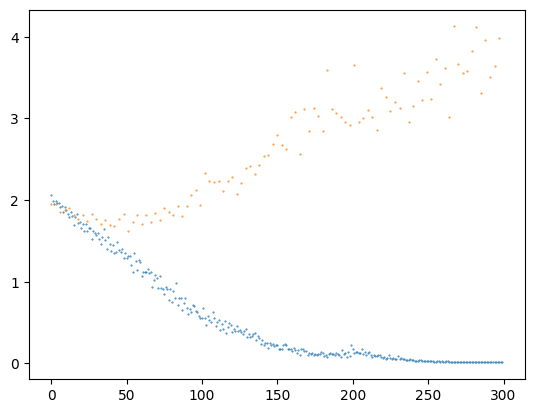

In [18]:
import matplotlib.pyplot as plt

# Save and plot losses
torch.save(train_losses,f="train_losses_model_3.pt")
torch.save(val_losses,f="val_losses_model_3.pt")

t1 = np.arange(len(train_losses))
t2 = train_size/val_size*np.arange(len(val_losses))
plt.scatter(t1,train_losses,s=0.2)
plt.scatter(t2,val_losses,s=0.2)
plt.show()

<p>Evaluate.</p>

In [19]:
speech_classifier.eval()
y_tests = np.array([])
y_preds = np.array([])
for i, ((X_test, X_lengths), y_test) in enumerate(test_loader):
    y_pred = speech_classifier(X_test,X_lengths).softmax(dim=1).argmax(dim=1)
    y_tests = np.concatenate((y_tests,y_test))
    y_preds = np.concatenate((y_preds,y_pred))
print(i)

0


In [20]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_tests,y_preds,target_names=possible_parties))

              precision    recall  f1-score   support

           S       0.40      0.49      0.44       100
          SD       0.24      0.22      0.23        45
           M       0.39      0.51      0.44       106
           V       0.47      0.32      0.38        57
           C       0.25      0.18      0.21        44
          MP       0.10      0.08      0.09        36
          KD       0.31      0.28      0.29        61
           L       0.27      0.22      0.24        51

    accuracy                           0.34       500
   macro avg       0.30      0.29      0.29       500
weighted avg       0.33      0.34      0.33       500

